# Student Loans
An upcoming financial institution wants to specialize in student loans and has contacted us in September of 2013 to look at their data.<br/>
You are given three datasets:
* college_features_2012_2013/2013_2014: contains general information about US colleges
* loans_2012_2013: contains the amount and type of loans given to students studying at US colleges
* default_rates_2012_2013/2011_2012: contains default rates of student loans studying at US colleges

Your task is to answer following questions as accurately as possible. Questions one and two will assess your general insight and business acumen. Questions three to six will test your data-analysis skills. Here you are not required to come up with a fully functional solution, however you should properly articulate your proposed approach on solving these problems.

__Author: Daniel Grzebyk__

__Date: 21.12.2020__

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from functions import display_component

C:\Users\danie\anaconda3\envs\o9\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Load data
college_features_2014 = pd.read_csv('data/student_loans/Current Data/college_features_2013_2014.csv', index_col=['unitid'])
college_features_df = pd.read_csv('data/student_loans/Historical Data/college_features_2012_2013.csv') # , index_col=['unitid']
loans_df = pd.read_csv('data/student_loans/Historical Data/loans_2012_2013.csv') # , index_col=['opeid']
rates_df = pd.read_csv('data/student_loans/Historical Data/default_rates_2012_2013.csv') # , index_col=['opeid']
rates_old_df = pd.read_csv('data/student_loans/Historical Data/default_rates_2011_2012.csv') # , index_col=['opeid']

features_description = pd.read_csv('data/student_loans/Historical Data/college_features_description.csv')
loans_description = pd.read_csv('data/student_loans/Historical Data/loans_description.csv')

## Data Cleaning

In [3]:
# Display the % of NaNs for each column
# print(loans_df.isna().sum()) # <-- no NaNs
# print(rates_df.isna().sum()) # <-- no NaNs
nans_fraction = college_features_df.isna().sum() / len(college_features_df) * 100
nans_fraction[nans_fraction > 25]

admission_rate                                                 70.370846
admission_rate.all_campuses                                    66.187604
sat_score_average                                              81.688695
sat_score_average.all_campuses                                 80.238676
average_faculty_salary                                         42.563839
full_time_faculty                                              46.888233
completion_rate_4yr_studies_150%_of_expected_time              68.907994
completion_rate_less_than_4yr_studies_150%_of_expected_time    49.659951
completion_rate_4yr_studies_200%_of_expected_time              73.078404
completion_rate_less_than_4yr_studies_200%_of_expected_time    51.905556
dtype: float64

After manual investigation it was discovered that the above features have more than 42 % of missing values. This means using them for further analysis would remove almost half of the US colleges from the data set. Therefore, the features listed above are dropped.

In [4]:
# Drop columns containing more than 25 % of missing values
old_features = college_features_df.columns
print("Shape before:", college_features_df.shape)
college_features_df.dropna(thresh=len(college_features_df) * 0.75, axis=1, inplace=True)
print("Shape after: ", college_features_df.shape)
new_features = college_features_df.columns
dropped_features = set(old_features) - set(new_features)
print(f"Dropped {len(dropped_features)} features: \n\n", dropped_features)

Shape before: (7793, 74)
Shape after:  (7793, 64)
Dropped 10 features: 

 {'completion_rate_less_than_4yr_studies_200%_of_expected_time', 'sat_score_average.all_campuses', 'admission_rate', 'completion_rate_4yr_studies_150%_of_expected_time', 'admission_rate.all_campuses', 'completion_rate_less_than_4yr_studies_150%_of_expected_time', 'full_time_faculty', 'average_faculty_salary', 'completion_rate_4yr_studies_200%_of_expected_time', 'sat_score_average'}


In [5]:
# Drop rows containing missing values
print("Shape before:", college_features_df.shape)
college_features_df.dropna(axis=0, inplace=True)
print("Shape after: ", college_features_df.shape)

Shape before: (7793, 64)
Shape after:  (6799, 64)


In [6]:
print("Present dataframe shapes:")
print("Colleges: ", college_features_df.shape)
print("Loans:    ", loans_df.shape)
print("Rates:    ", rates_df.shape)

Present dataframe shapes:
Colleges:  (6799, 64)
Loans:     (5650, 28)
Rates:     (4712, 9)


In [7]:
# Identify feature types
college_features_df.select_dtypes(include='number').columns

Index(['unitid', 'opeid', 'is_main_campus', 'number_of_branch_campuses',
       'control', 'region', 'program_percentage.agriculture',
       'program_percentage.resources', 'program_percentage.architecture',
       'program_percentage.ethnic_cultural_gender',
       'program_percentage.communication',
       'program_percentage.communications_technology',
       'program_percentage.computer', 'program_percentage.personal_culinary',
       'program_percentage.education', 'program_percentage.engineering',
       'program_percentage.engineering_technology',
       'program_percentage.language',
       'program_percentage.family_consumer_science',
       'program_percentage.legal', 'program_percentage.english',
       'program_percentage.humanities', 'program_percentage.library',
       'program_percentage.biological', 'program_percentage.mathematics',
       'program_percentage.military', 'program_percentage.multidiscipline',
       'program_percentage.parks_recreation_fitness',
       '

In [8]:
college_features_df.select_dtypes(include='category').columns

Index([], dtype='object')

In [9]:
college_features_df.select_dtypes(include='object').columns

Index(['name', 'city', 'state', 'zip'], dtype='object')

_It is important to remember that correlation is not causation, and even though a person's origin might be correlated with his/her financial success, ethnicity should not be included while predicting the most profitable customers (or colleges). It is important than the created models remain racially unbiased._

In [10]:
# Drop features which introduce racial bias
demographic_features = ['demographics.race_ethnicity.white',
                       'demographics.race_ethnicity.black',
                       'demographics.race_ethnicity.hispanic',
                       'demographics.race_ethnicity.asian',
                       'demographics.race_ethnicity.aian',
                       'demographics.race_ethnicity.nhpi',
                       'demographics.race_ethnicity.two_or_more',
                       'demographics.race_ethnicity.non_resident_alien',
                       'demographics.race_ethnicity.unknown']

college_features_df.drop(columns=demographic_features, inplace=True)

### Looking for Outliers

In [11]:
# Analyze program percentages separately
program_percentage = ['program_percentage.agriculture',
       'program_percentage.resources','program_percentage.architecture',
       'program_percentage.ethnic_cultural_gender',
       'program_percentage.communication',
       'program_percentage.communications_technology',
       'program_percentage.computer', 'program_percentage.personal_culinary',
       'program_percentage.education', 'program_percentage.engineering',
       'program_percentage.engineering_technology',
       'program_percentage.language',
       'program_percentage.family_consumer_science',
       'program_percentage.legal', 'program_percentage.english',
       'program_percentage.humanities', 'program_percentage.library',
       'program_percentage.biological', 'program_percentage.mathematics',
       'program_percentage.military', 'program_percentage.multidiscipline',
       'program_percentage.parks_recreation_fitness',
       'program_percentage.philosophy_religious',
       'program_percentage.theology_religious_vocation',
       'program_percentage.physical_science',
       'program_percentage.science_technology',
       'program_percentage.psychology',
       'program_percentage.security_law_enforcement',
       'program_percentage.public_administration_social_service',
       'program_percentage.social_science', 'program_percentage.construction',
       'program_percentage.mechanic_repair_technology',
       'program_percentage.precision_production',
       'program_percentage.transportation',
       'program_percentage.visual_performing', 'program_percentage.health',
       'program_percentage.business_marketing', 'program_percentage.history']

In [12]:
# Looking for outliers in program percentages, confirming that program percentages stay between 0 and 1
college_features_df[program_percentage].sum(axis=1).describe()

count    6799.000000
mean        0.992206
std         0.087953
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000600
dtype: float64

In [13]:
college_features_df.drop(columns=program_percentage).select_dtypes(include='number').describe()

,unitid,opeid,is_main_campus,number_of_branch_campuses,control,region,distance_only,undergrad_enrollment_size,part_time_students_share,net_tuition_revenue_per_full_time_equivalent_student,instructional_expenditure_per_fte,pell_grant_undergratuates_percentage,share_first_time_full_time_students
count,6799.000000,6799.000000,6799.000000,6799.000000,6799.000000,6799.000000,6799.000000,6799.000000,6799.000000,6.799000e+03,6799.000000,6799.000000,6799.000000
mean,278724.481541,15999.392411,0.779526,7.334314,2.204883,4.621121,0.003971,2461.851155,0.222103,9.275990e+03,6075.956464,0.537395,0.674417
std,130197.322147,13436.423390,0.414597,23.179205,0.857928,2.160247,0.062897,5772.607406,0.237680,1.477162e+04,9911.453454,0.223578,0.277313
min,100654.000000,1002.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,169725.000000,3491.000000,1.000000,1.000000,1.000000,3.000000,0.000000,136.000000,0.000000,3.825000e+03,2950.000000,0.368450,0.476945
50%,220808.000000,10490.000000,1.000000,1.000000,2.000000,5.000000,0.000000,498.000000,0.151700,8.015000e+03,4706.000000,0.532300,0.706897
75%,438276.000000,25624.000000,1.000000,2.000000,3.000000,6.000000,0.000000,2084.500000,0.377400,1.253850e+04,7087.000000,0.711550,0.953987
max,480523.000000,42176.000000,1.000000,141.000000,3.000000,9.000000,1.000000,205286.000000,1.000000,1.056528e+06,606843.000000,1.000000,1.000000


Suspiciously large differences between max value and the third quartile are observed in _number_of_branch_campuses, undergrad_enrollment_size, net_tuition_revenue_per_full_time_equivalent_student, instructional_expenditure_per_fte_.

In [20]:
# This seems to be right-skewed normal distribution
# If it is a normal distribution we can drop outliers grear than 3 sigma



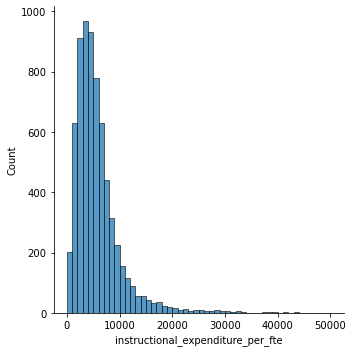

In [21]:
sns.displot(data=college_features_df, x="instructional_expenditure_per_fte", binwidth=1000, binrange=(0, 50000))

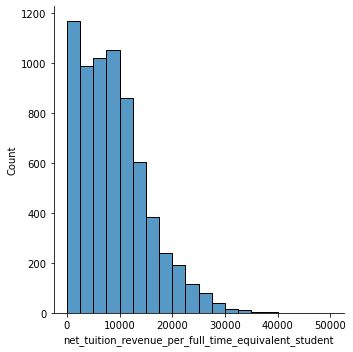

In [14]:
sns.displot(data=college_features_df, x="net_tuition_revenue_per_full_time_equivalent_student", 
            binwidth=2500, binrange=(0,50000))

75th quantile:  2.0
95th quantile:  31.0


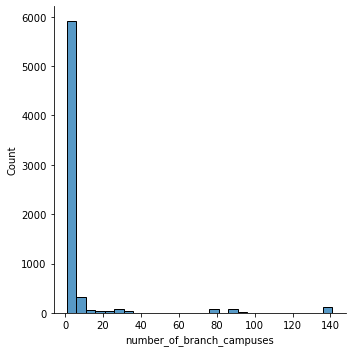

In [19]:
q75 = college_features_df['number_of_branch_campuses'].quantile(0.75)
q95 = college_features_df['number_of_branch_campuses'].quantile(0.95)
print("75th quantile: ", q75)
print("95th quantile: ", q95)
sns.displot(data=college_features_df, x="number_of_branch_campuses", palette="black", binwidth=5)
plt.show()
plt.close()

In [16]:
# Count outliers
print(college_features_df[college_features_df['net_tuition_revenue_per_full_time_equivalent_student'] > 50000].shape)
print(college_features_df[college_features_df['instructional_expenditure_per_fte'] > 50000].shape)
print(college_features_df[college_features_df['number_of_branch_campuses'] > 40].shape)

(16, 54)
(20, 54)
(312, 54)


In this study analysing outliers in not critical, as they would be in case of anomaly detection or predictive maintenance. Outliers are also a minority of the data. Therefore, for simplicity the outliers can be safely removed. Dropping the outliers below removes colleges with net tuition revenue or instructional expenditure per fte student exceeding 50,000 USD. This eliminates very expensive schools from the analysis. 

On the other hand, it is unlikely that a college has tuition fee exceeding 1 mln USD which probably is an example of corrupt data.

It was decided not to remove colleges with suspiciously large number of campuses (141). <-- WHY?

In [17]:
# Drop outliers
college_features_df = college_features_df[college_features_df['instructional_expenditure_per_fte'] <= 50000]
college_features_df = college_features_df[college_features_df['net_tuition_revenue_per_full_time_equivalent_student'] <= 50000]
# college_features_df = college_features_df[college_features_df['number_of_branch_campuses'] <= 40]

In [47]:
loans_df.describe()

,opeid,subsidized_disbursements_nb,unsubsidized_undergraduate_disbursements_nb,unsubsidized_graduate_disbursements_nb,parent_plus_disbursements_nb,graduate_plus_disbursements_nb
count,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.00000
mean,16242.311504,2811.530442,2774.193628,646.747611,264.414690,154.43292
std,14395.899789,9536.575982,9890.472572,3521.183155,830.863571,747.94338
min,1002.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3165.250000,108.000000,97.250000,0.000000,0.000000,0.00000
50%,10059.500000,646.000000,573.000000,0.000000,16.000000,0.00000
75%,30107.750000,2582.000000,2523.750000,133.000000,164.000000,4.00000
max,42371.000000,430659.000000,449764.000000,108652.000000,18396.000000,16892.00000


In [29]:
rates_df.describe()

,opeid,number_of_defaults,number_of_loans,default_rate
count,4712.000000,4712.000000,4712.000000,4712.000000
mean,14491.962436,120.747453,1094.505518,10.609041
std,14059.273862,516.664124,3690.023766,7.583603
min,1002.000000,0.000000,0.000000,0.000000
25%,2847.750000,7.000000,93.000000,4.400000
50%,7691.500000,26.500000,337.000000,9.300000
75%,25124.750000,105.000000,1029.000000,15.700000
max,42636.000000,26004.000000,194107.000000,60.000000


In [54]:
rates_df.sort_values(by='number_of_loans', ascending=False).head()

,opeid,name,address,city,state,zip,number_of_defaults,number_of_loans,default_rate
3049,20988,UNIVERSITY OF PHOENIX ...,1625 WEST FOUNTAINHEAD PARKWAY ...,TEMPE,AZ,85282,26004,194107,13.3
566,1881,ASHFORD UNIVERSITY ...,8620 SPECTRUM CENTER BOULEVARD ...,SAN DIEGO,CA,92123,7545,51710,14.5
2759,10727,DEVRY UNIVERSITY ...,3300 NORTH CAMPBELL ...,CHICAGO,IL,60618,5388,50685,10.6
2644,9917,IVY TECH COMMUNITY COLLEGE OF INDIANA ...,50 WEST FALL CREEK PARKWAY NORTH DRIVE...,INDIANAPOLIS,IN,46208,9142,40497,22.5
312,1499,EVEREST UNIVERSITY ...,3319 WEST HILLSBOROUGH AVENUE ...,TAMPA,FL,33614,10377,38626,26.8


University of Phoenix is clearly an outlier in terms of number of loans and number of defaults. 

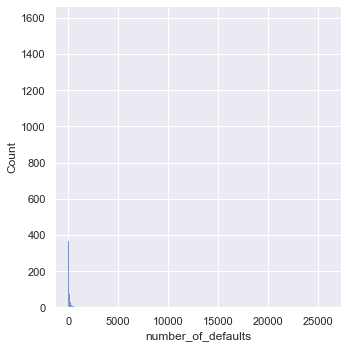

In [33]:
sns.displot(data=rates_df, x="number_of_defaults") # , binwidth=1000, binrange=(0, 50000))

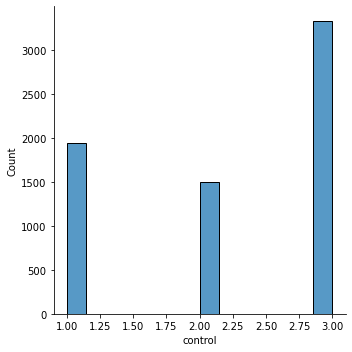

In [22]:
# undergrad_enrollment_size, number_of_branch_campuses
sns.displot(data=college_features_df, x="control", palette="black")

In [20]:
# Clean features to conveniently manipulate dataframes
loans_df = loans_df.replace({'\$-':0,'\$':'',"\,":'',"-":0}, regex = True)
rates_df = rates_df.replace({'\$-':0,'\$':'',"\,":'',"-":0}, regex = True)

### End of looking for outliers

Alignment drops all colleges which are not present in all three DataFrames. This decision is valid, as data from all three data sources is required to give informed answers in the exercies below.

In [23]:
# Combine all three data sources into one dataframe for easy visualization
colleges = college_features_df.copy().set_index('opeid')
loans = loans_df.copy().set_index('opeid')
rates = rates_df.copy().set_index('opeid')

features = colleges.join(loans.drop(columns=['name','state']), on='opeid', how="left")
features = features.join(rates.drop(columns=['name','address','city','state','zip']), on='opeid', how="left")

# Save opeid as a feature
features['opeid'] = features.index

# Use unitid as index
features.set_index("unitid", inplace=True)

duplicates_count = features.index.duplicated().sum()

print(f"INFO: features DataFrame contains {duplicates_count} duplicate indexes")

features.head()

INFO: features DataFrame contains 0 duplicate indexes


,name,city,state,zip,is_main_campus,number_of_branch_campuses,control,region,program_percentage.agriculture,program_percentage.resources,...,parent_plus_disbursements_usd,graduate_plus_recipients,graduate_plus_loans_originated_nb,graduate_plus_loans_originated_usd,graduate_plus_disbursements_nb,graduate_plus_disbursements_usd,number_of_defaults,number_of_loans,default_rate,opeid
unitid,,,,,,,,,,,,,,,,,,,,,
100654,Alabama A & M University,Normal,AL,35762,1,1,1,5,0.0451,0.015,...,"$4,295,525.00",42,54,"$288,898.00",100.0,"$288,897.00",300.0,1812.0,16.5,1002
100663,University of Alabama at Birmingham,Birmingham,AL,35294-0110,1,1,1,5,0.0000,0.000,...,"$3,775,816.00",463,527,"$7,122,307.00",1079.0,"$6,939,348.00",223.0,4159.0,5.3,1052
100690,Amridge University,Montgomery,AL,36117-3553,1,1,2,5,0.0000,0.000,...,"$6,680.00",31,31,"$472,465.00",74.0,"$462,888.00",38.0,380.0,10.0,25034
100706,University of Alabama in Huntsville,Huntsville,AL,35899,1,1,1,5,0.0000,0.000,...,"$1,842,586.00",18,26,"$165,297.00",33.0,"$165,241.00",77.0,1464.0,5.2,1055
100724,Alabama State University,Montgomery,AL,36104-0271,1,1,1,5,0.0000,0.000,...,"$4,051,266.00",54,74,"$442,206.00",118.0,"$442,206.00",367.0,2196.0,16.7,1005


In [24]:
# Look for missing values caused by unequal number of rows in the initial 3 dataframes
nans_per_feature = features.isna().sum()
nans_per_feature[nans_per_feature.values > 0]

subsidized_recipients                               650
subsidized_loans_originated_nb                      650
subsidized_loans_originated_usd                     650
subsidized_disbursements_nb                         650
subsidized_disbursements_usd                        650
unsubsidized_undergraduate_recipients               650
unsubsidized_undergraduate_loans_originated_nb      650
unsubsidized_undergraduate_loans_originated_usd     650
unsubsidized_undergraduate_disbursements_nb         650
unsubsidized_undergraduate_disbursements_usd        650
unsubsidized_graduate_recipients                    650
unsubsidized_graduate_loans_originated_nb           650
unsubsidized_graduate_loans_originated_usd          650
unsubsidized_graduate_disbursements_nb              650
unsubsidized_graduate_disbursements_usd             650
parent_plus_recipients                              650
parent_plus_loans_originated_nb                     650
parent_plus_loans_originated_usd                

In [25]:
# Remove missing values which occured after merging
features.dropna(inplace=True)

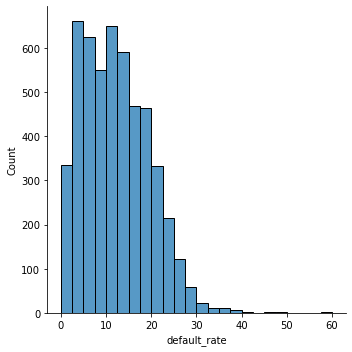

In [27]:
# Is the default rate normally distributed?
sns.displot(data=features, x="default_rate", palette="black", binwidth=2.5)

### Q1: If given the chance, what would you try to predict, given this dataset? How would you try to achieve this? (you can suggest multiple possibilities, ranked by importance)

### A1:
**Things I would  try to predict**:
Default rate, amount borrowed per student per university, 

Firstly, I would like to predict in which colleges students borrow the most frequently and the largest amounts. This would involve looking for features which make students endebt themselves more. Does it matter whether the school is public or private? Is it releveant whether parents back up the loans? Is it important where the school is located? Location is important because of state laws, local culture etc., but should be treated carefully, as using e.g. zip code might introduce economic segregation to the model. 

Secondly, I would like to predict the default rate for each college. I assume that students who obtained higher quality education and have smaller debts are more likely to succeessfully pay them back. 

Thirdly, I would like to predict the number of loans per college. This is important for the client to estimate the administrative costs associated with giving loans.

**How I would try to achieve this**:
In order to predict the above, I would use college features to train a regression algorithm. I would also use squared error loss function for training to make sure my models avoid making large mistakes. The evaluation metric would be Mean Absolute Error, as it clearly describes by how many USD (in case of borrowed amount), loans (in case of number of loans) or % (in case of default rate) the model is mistaken. Also, it is important to notice that rates and loans data cannot be used for model training, as they are available only for the past academic year. 

When predicting profits per college it is important to use a benchmark model for additional validation. Calculating profits once giving loans at randomly selected universities could be compared with giving loans at the selected colleges only.

### Q2: Why is this relevant to the company's bottom line? Explain the impact of an accurate prediction on the company's workflow and rudimentarily formulate its influence on company profits mathematically. 

Predicting the schools where students have loans with the highest interest rate and borrowed the highest amounts is important, as only schools where there is demand are interesting to the client. As only successfully paid back loans are profitable, predicting default rates helps to estimate the risk associated with the investments. Predicting the amount of borrowed dollars for each school informs the client about the required resources neccessary to enter every college.

For further calculations I assume that the time and bureucracy necessary to give a loan are negligible, and the only cost which I should focus on are the unpaid loans. Successfully paid back loans improve the company's financial situation with interest being its profit. Loans failed to be paid back mean the company gave the funds, but never fully got them back and got little or zero interest. Therefore, costs of a single bad decision (unpaid loan) are far greater than the benefits of a single good decision (paid back loan + interest). Hence, predictive models should minimize the number of false positives. 

_company profts described mathematically_:

profits = interest_rate * total_borrowed_money - number_of_loans * administrative_cost_of_one_loan - default_rate * total_borrowed_money

It should be confirmed that _default rate_ refers to the **amount of unpaid USD** rather than the **number of unpaind loans**.

### Q3: Find and display graphically as many relevant insights as possible. What is contained in your graphs and why are your conclusions important? 

Created visualizations include:
1. Colleges per state
2. Loans per state vs. colleges per state
3. Tuition vs. Instructional Expenditure
4. Pell grants vs. default rate
5. Instructional_expenditure_per_fte vs. default rate
6. Tuition Revenue vs. Instructional Expenditure
7. Number of loans per school
8. Program_percentage vs. default rate - correlations
9. Number of defaults vs. number of parent-backed loans
10. Part time student share vs. default rate

The exploratory data analysis below is performed only on values which are actually used for models training and evaluation. Therefore _features_ DataFrame is used.

#### 1. Colleges per state
Plotted to see whether some states have more colleges than others, and hence might be a better place for the client to start the company.

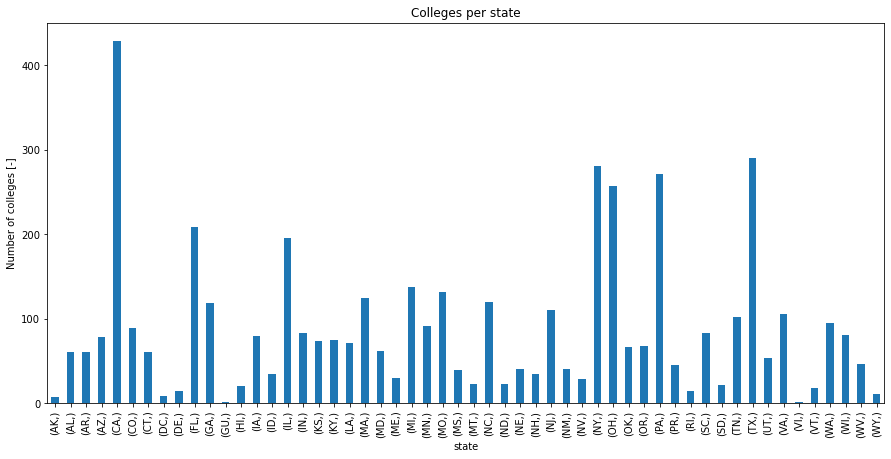

In [26]:
plt.figure(figsize=(15,7))
features[['state']].value_counts().sort_index().plot(kind='bar')
plt.ylabel("Number of colleges [-]")
plt.title("Colleges per state")
plt.show()
plt.close()

#### 2. Loans per state vs. colleges per state
Plotted to check whether more colleges actually mean more loans are taken at a particular state. As can be seen below, there is a clear correlation between the number of colleges and the number of loans. 

It also means that student loans are not a local phenomenon characteristic for a single state, but are present across all US. <-- to be corrected

Is the trend linear or exponential?

In [27]:
features['unsubsidized_undergraduate_disbursements_usd'] = features['unsubsidized_undergraduate_disbursements_usd'].apply(lambda x: x.split('.')[0] if isinstance(x,int)==False else x)
features['unsubsidized_undergraduate_disbursements_usd'] = features['unsubsidized_undergraduate_disbursements_usd'].astype('int64')

disbursements_per_state = features.groupby('state').sum()['unsubsidized_undergraduate_disbursements_usd']
colleges_per_state = features[['state']].value_counts().sort_index()

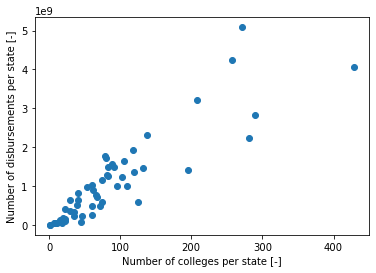

In [28]:
plt.scatter(colleges_per_state, disbursements_per_state)
plt.ylabel("Number of disbursements per state [-]")
plt.xlabel("Number of colleges per state [-]")
plt.show()
plt.close()

#### 3. Net Revenue per Student vs. Instructional Expenditure per Student
This graph is plotted to check whether correlation between tuition fee and the actual spendings per student exists. No correlation was observed which can be explained by governmental subsidies analyzed further below. 

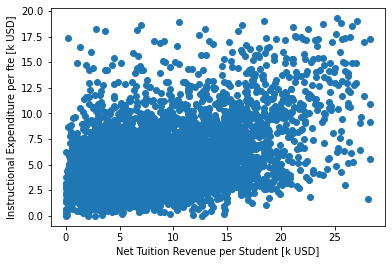

In [29]:
plt.scatter(features[['net_tuition_revenue_per_full_time_equivalent_student']] / 1000,
            features[['instructional_expenditure_per_fte']] / 1000)
# plt.title("Education Value Cost-Benefit Analysis")
plt.xlabel("Net Tuition Revenue per Student [k USD]")
plt.ylabel("Instructional Expenditure per fte [k USD]")
plt.show()
plt.close()

#### 4. Pell Grants vs. Default Rate
This graph is plotted to see whether colleges with more Pell grants have alumni who are more likely to pay back their loans. As can be seen below, no correlation was observed which means this factor does not have much impact on determining whether a student should get a student loan or not, or whether a college should be targeted with loans offer or not.

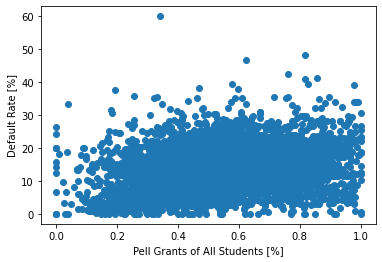

In [30]:
plt.scatter(features[['pell_grant_undergratuates_percentage']],
            features['default_rate'])
plt.xlabel("Pell Grants of All Students [%]")
plt.ylabel("Default Rate [%]")
plt.show()
plt.close()

#### 5. Instructional Expenditure per Student vs. Default Rate
This graph was plotted to check whether students success is correlated with the amount of money a university spends on their education. As expected, a significant correlation exists and the largest default rates are characteristic for colleges with low instructional spendings per student. Above instructional expenditure of around 15,000 USD per student the default rate flattens. This might mean that in colleges spending above this threshold students success depends on their personal motivation/skills rather than the physical resources.

Outliers exist, e.g. in the right upper corner there is a college which has very high instructional fee and very high default rate.

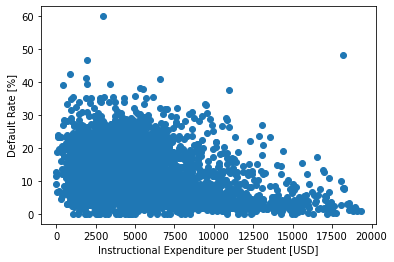

In [31]:
# Instructional expenditure vs. default rate
plt.scatter(features[['instructional_expenditure_per_fte']],
            features['default_rate'])
plt.xlabel("Instructional Expenditure per Student [USD]")
plt.ylabel("Default Rate [%]")
plt.show()
plt.close()

In [32]:
features[['instructional_expenditure_per_fte','default_rate']].corr()

,instructional_expenditure_per_fte,default_rate
instructional_expenditure_per_fte,1.000000,-0.391108
default_rate,-0.391108,1.000000


#### 6. Tuition Revenue vs. Instructional Expenditure

Clearly, not in all schools high tuition fees go along with high expenditure on students. Dots in the right bottom corner correspond to schools having relatively high fees and small % expenditure on students. Dots in the left upper corner correspond to schools which have relatively small tuition fees, but have large expenses on education. That is probably caused by the governmental subsidies.

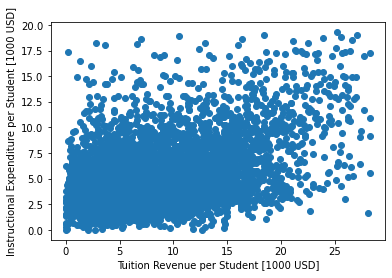

In [33]:
plt.scatter(features['net_tuition_revenue_per_full_time_equivalent_student'] / 1000,
            features['instructional_expenditure_per_fte'] / 1000)

plt.xlabel("Tuition Revenue per Student [1000 USD]")
plt.ylabel("Instructional Expenditure per Student [1000 USD]")
plt.show()
plt.close()

In [34]:
# control,"1: public, 2: private non-profit, 3:private for-profit"
features['education_expense_%'] = round(features['instructional_expenditure_per_fte'] / features['net_tuition_revenue_per_full_time_equivalent_student'] * 100, 2)

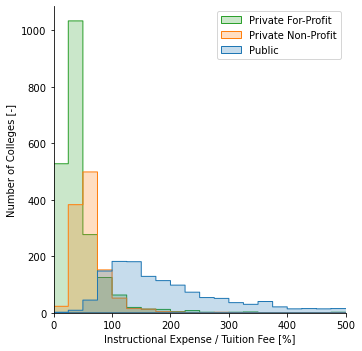

In [35]:
# Remove infinities caused by free schools
education_hist = features[['education_expense_%','control']].replace([np.inf, -np.inf], np.nan).dropna().copy()

# Display 3 histograms, one for each control class
sns.displot(education_hist, x="education_expense_%", hue="control", element="step", binwidth=25, palette='tab10',# 'tab10'
            legend=False)

plt.xlim([0,500])
# plt.ylim([0,1000])
plt.legend(["Private For-Profit",'Private Non-Profit','Public'])
plt.xlabel("Instructional Expense / Tuition Fee [%]")
plt.ylabel("Number of Colleges [-]")
plt.show()
plt.close()

According to the histogram above, public schools tend to offer better value for money, as instructional expenses per student there frequently exceed the individual tuition fee. 

In [36]:
subsidized_public_col = sum(features[features['control']==1]['education_expense_%'] > 100)
subsidized_non_profit_col = sum(features[features['control']==2]['education_expense_%'] > 100)
subsidized_for_profit_col = sum(features[features['control']==3]['education_expense_%'] > 100)

print(f"Number of public subsidized colleges            : {subsidized_public_col}")
print(f"Number of private non profit subsidized colleges: {subsidized_non_profit_col}")
print(f"Number of private for profit subsidized colleges: {subsidized_for_profit_col}")

Number of public subsidized colleges            : 1234
Number of private non profit subsidized colleges: 105
Number of private for profit subsidized colleges: 150


In [37]:
print("Median instructional expense / tuition fee in public colleges            :",
      features[features['control']==1]['education_expense_%'].median(), "%")
print("Median instructional expense / tuition fee in private non-profit colleges: ",
      features[features['control']==2]['education_expense_%'].median(), "%")
print("Median instructional expense / tuition fee in private for-profit colleges: ",
      features[features['control']==3]['education_expense_%'].median(), "%")

Median instructional expense / tuition fee in public colleges            : 180.05 %
Median instructional expense / tuition fee in private non-profit colleges:  56.45 %
Median instructional expense / tuition fee in private for-profit colleges:  35.269999999999996 %


Clearly, public colleges get more subsidies and offer better value for money than the private ones. This is an interesting observation, however, it is insufficient to determine whether graduates from public colleges are more likely to pay back their loans.

In [38]:
features[['education_expense_%','default_rate']].corr()

,education_expense_%,default_rate
education_expense_%,1.000000,0.067019
default_rate,0.067019,1.000000


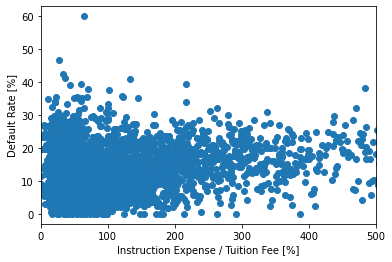

In [39]:
plt.scatter(features['education_expense_%'], features['default_rate'])
plt.xlim([0,500])
plt.xlabel("Instruction Expense / Tuition Fee [%]")
plt.ylabel("Default Rate [%]")
plt.show()
plt.close()

In [40]:
features['education_expense_%'].describe()

count    4716.0000
mean           inf
std            NaN
min         0.0000
25%        35.6400
50%        58.8900
75%       126.2325
max            inf
Name: education_expense_%, dtype: float64

In [41]:
features.drop(columns=['education_expense_%'], inplace=True)

#### 7. Number of loans per school / per city
Below, I identify schools where students take loans the most frequently.

In [42]:
features[["number_of_loans"]].describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_loans,4717.0,2043.003816,5238.27582,0.0,147.0,536.0,1543.0,50685.0


In [43]:
features.sort_values(by='number_of_loans', ascending=False).head()

,name,city,state,zip,is_main_campus,number_of_branch_campuses,control,region,program_percentage.agriculture,program_percentage.resources,...,parent_plus_disbursements_usd,graduate_plus_recipients,graduate_plus_loans_originated_nb,graduate_plus_loans_originated_usd,graduate_plus_disbursements_nb,graduate_plus_disbursements_usd,number_of_defaults,number_of_loans,default_rate,opeid
unitid,,,,,,,,,,,,,,,,,,,,,
450517,DeVry University-Tennessee,Memphis,TN,38119-4808,0,26.0,3,5,0.0,0.0,...,16313313.00,6,8,50807.00,18.0,47675.00,5388.0,50685.0,10.6,10727
440545,DeVry University-Washington,Federal Way,WA,98001-9558,0,26.0,3,8,0.0,0.0,...,16313313.00,6,8,50807.00,18.0,47675.00,5388.0,50685.0,10.6,10727
454209,DeVry University-Kentucky,Louisville,KY,40223-3887,0,26.0,3,5,0.0,0.0,...,16313313.00,6,8,50807.00,18.0,47675.00,5388.0,50685.0,10.6,10727
444033,DeVry University-Oregon,Portland,OR,97225-6651,0,26.0,3,8,0.0,0.0,...,16313313.00,6,8,50807.00,18.0,47675.00,5388.0,50685.0,10.6,10727
224402,DeVry University-Texas,Irving,TX,75063-2439,0,26.0,3,6,0.0,0.0,...,16313313.00,6,8,50807.00,18.0,47675.00,5388.0,50685.0,10.6,10727


In [44]:
features.groupby('city')['number_of_loans'].sum().sort_values(ascending=False).head()

city
Phoenix         174370.0
Indianapolis    115963.0
Milwaukee        98141.0
Louisville       94090.0
Columbus         92229.0
Name: number_of_loans, dtype: float64

In [45]:
loans_median = features['number_of_loans'].median()
print(f"Median number of loans per school is {round(loans_median)}. Mean is not of interest in this case, as it might be "
      "skewed by outliers.")

Median number of loans per school is 536. Mean is not of interest in this case, as it might be skewed by outliers.


#### 8. Program % vs. Default Rate
Do universities which have more programs of a particular kind (e.g. mathematics, humanities etc.) have students who are more likely to pay back their loans? As can be seen below, there were no large positive correlations, hence subjects decreasing the likelihood of success could not be identified. Program percentages of mathematics, biology, social science and history are negatively correlated with the default rate which implies their graduates tend do be more successful than their peers who studied different domains. This however does not imply the alumni are more successfull **because** of the subject they studied.

In [46]:
correlations = features[['program_percentage.agriculture', 'program_percentage.resources',
                         'program_percentage.architecture',
                         'program_percentage.ethnic_cultural_gender',
                         'program_percentage.communication',
                         'program_percentage.communications_technology',
                         'program_percentage.computer', 'program_percentage.personal_culinary',
                         'program_percentage.education', 'program_percentage.engineering',
                         'program_percentage.engineering_technology',
                         'program_percentage.language',
                         'program_percentage.family_consumer_science',
                         'program_percentage.legal', 'program_percentage.english',
                         'program_percentage.humanities', 'program_percentage.library',
                         'program_percentage.biological', 'program_percentage.mathematics',
                         'program_percentage.military', 'program_percentage.multidiscipline',
                         'program_percentage.parks_recreation_fitness',
                         'program_percentage.philosophy_religious',
                         'program_percentage.theology_religious_vocation',
                         'program_percentage.physical_science',
                         'program_percentage.science_technology',
                         'program_percentage.psychology',
                         'program_percentage.security_law_enforcement',
                         'program_percentage.public_administration_social_service',
                         'program_percentage.social_science', 'program_percentage.construction',
                         'program_percentage.mechanic_repair_technology',
                         'program_percentage.precision_production',
                         'program_percentage.transportation',
                         'program_percentage.visual_performing', 'program_percentage.health',
                         'program_percentage.business_marketing', 'program_percentage.history','default_rate']].corr()

In [47]:
correlations[['default_rate']][correlations[['default_rate']] < -0.2].dropna().sort_values(by='default_rate')

,default_rate
program_percentage.history,-0.347318
program_percentage.biological,-0.308525
program_percentage.social_science,-0.307973
program_percentage.mathematics,-0.298314
program_percentage.language,-0.284367
program_percentage.english,-0.236039
program_percentage.psychology,-0.225152


In [48]:
correlations[['default_rate']][correlations[['default_rate']] > 0.1].dropna().sort_values(by='default_rate', ascending=False)

,default_rate
default_rate,1.000000
program_percentage.humanities,0.177077
program_percentage.health,0.133185
program_percentage.security_law_enforcement,0.130096
program_percentage.construction,0.108617


#### 9. Number of defaults vs. Number of Parent-Backed Up Loans
Are loans backed up by parents safer for the client than the loans taken by students alone? It can be seen that with parental help the default rate rapidly decreases. 

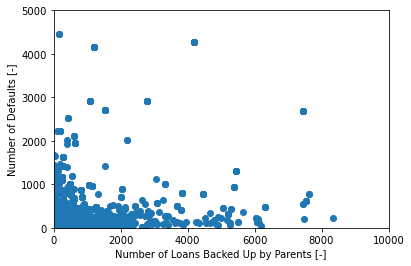

In [49]:
plt.scatter(features['parent_plus_disbursements_nb'].astype('int64'), features['number_of_defaults'])
plt.xlim([0,10000])
plt.ylim([0,5000])
plt.ylabel("Number of Defaults [-]")
plt.xlabel("Number of Loans Backed Up by Parents [-]")
plt.show()
plt.close()

In [50]:
features[['parent_plus_disbursements_nb','number_of_defaults']].corr()

,parent_plus_disbursements_nb,number_of_defaults
parent_plus_disbursements_nb,1.00000,0.43591
number_of_defaults,0.43591,1.00000


#### 10. Part time student share vs. default rate
Is there any correlation between the fraction of part time students and the default rate? It was assumed it is more difficult to study part time than full-time, and a positive correlation between the ratio of part time students and the default rate was expected. However, no such correlation was discovered.

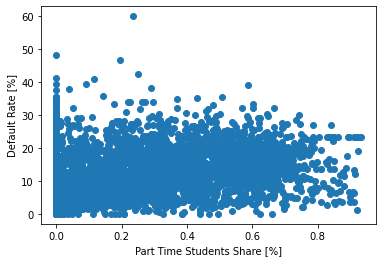

In [51]:
plt.scatter(features['part_time_students_share'], features['default_rate'])
plt.xlabel("Part Time Students Share [%]")
plt.ylabel("Default Rate [%]")
plt.show()
plt.close()

### Conclusions from the Exploratory Data Analysis:
The number of colleges per state varies, the most colleges are in California and taking study loans is common across all US. Colleges vary in terms of fraction of revenue they actually spend on students. Fraction of syudents with a Pell grant seems to have no impact on the default rates. 

The default rate is the highest in colleges with insufficient instructional expenses. This makes sense, as students who did not get the required time and attention from the lecturers are less likely to succeed in professional environment, which in turn decreases their chance to pay back their loans. After exceeding 15,000 USD in instructional expenses per student, the default rate stays relatively constant which means student success stops being dependent on the instructional expenses.

Public colleges tend to offer better value for money, followed by private non-profit and then private for-profit universities. That is because public institutions get higher governmental subsidies and therefore can have instructional expenses per student exceeding individual tuition fees. This makes students get higher value than the one they put in.

Cities with the largest number od loans are: Phoenix, Indianapolis, Milwaukee, Louisville and Columbus. It was difficult to assess whether technical universities tend to have smaller default rates than those teching humanities or vice versa. However, a small correlation between large fraction of history, social science, biology and mathematics and low default rates exists. 

Clearly, students who take loans with parental support are more likely to pay them back. This is important for the client while deciding whether to give a loan or not. It does not matter whether students study part-time or full-time from the perspective of the client.

From the above it can be concluded that the target college is public, has many parent-backed loans and instructional expenses exceeding 15,000 USD per fte student.

### Q4: If you had to set a fixed interest rate per school for the coming year (2013-2014), what would have to be the minimum for each school in order to break even? (hint: you will need to predict default rates, include these results in your answer)

Firstly, default rates are predicted for the academic year 2013-2014. In order to do so, influential feature selection is performed, next non-numerical features are encoded and regression is fit. Next, minimal interest rate per college is calculated following the equation:

_interest rate = total loss / (total loans - total loss)_ 

where _total_ refers to values summarized per university, **not** all values in the features dataframe

In [52]:
# Use only features present in college_features_df - e.g. loans_df are present only for the academic year 2012-2013,
# hence if used for training, it would not be possible to use the trained model to make predictions for the academic
# year 2013-2014

# Drop unnecessary or biased features - name is contained by unitid, region and city are already described by state
training_features = college_features_df.copy().set_index('unitid').drop(columns=['name','zip','opeid','region',
                                                                                 'city']).columns
xgb_features = features[training_features].copy()

# Encode non-numerical features
enc = OrdinalEncoder()
xgb_features['state'] = enc.fit_transform(xgb_features[['state']])

labels = features[['default_rate']]

RandomizedSearch already contains k-fold cross-validation and therefore creating a separate validation set is not required.

In [53]:
# Split data into training, validation and test set
X_train, X_test, y_train, y_test = train_test_split(xgb_features, labels, test_size=0.2)

In this case I use XGBoost algorithm to save time. XGBoost is computationally efficient and often wins Kaggle competitions. However, using Ockham's Razor for developing the simplest working solution is a good practice.

In [54]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             random_state=42,
                             n_jobs=-1)
# Normalize data
scaler = MinMaxScaler()

# Remove low-variance features
var_threshold = VarianceThreshold(threshold=0.01)

I normalize the data to compensate for differences in magnitudes of different features. I use also _sklearn.pipeline_ to prevent data leakage which could be caused by normalizing the dataset before splitting it into train and test sets.

In [55]:
pipe = Pipeline([('scaler', scaler), ('var_threshold', var_threshold), ('xgb', xgb_model)])

In case model training took significant amount of time, the usage of Principal Component Analysis could be considered. However, in this case single model fitting is almost instantaneous, hence PCA is not used.

In [56]:
params = {'xgb__learning_rate':[0.01,0.03,0.1,0.3],
          'xgb__max_depth':np.arange(2,20,2),
          'xgb__n_estimators':np.arange(0,200,10),
          'xgb__alpha':[0.01,0.03,0.1,0.3,1,3,10],
          'xgb__gamma':[0.01,0.03,0.1,0.3,1,3,10],
          'xgb__lambda':[0,0.01,0.03,1,3,10]
#           'xgb__colsample_bytree':np.arange(0,1.1,0.1)
         }

search = RandomizedSearchCV(pipe, param_distributions=params, n_iter=10, cv=10, return_train_score=True,
                            scoring='neg_mean_squared_error') # neg_mean_absolute_error,
                            
# search.fit(X_train, y_train)

# Load the trained model to save time and ensure results reproducibility
filename = 'trained_model_file.sav'
search = joblib.load(filename)

C:\Users\danie\anaconda3\envs\o9\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\danie\anaconda3\envs\o9\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.23.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\danie\anaconda3\envs\o9\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 1.1.0. This might lead to breaking code o

In [57]:
best_idx = search.best_index_

In [58]:
train_mae = abs(search.cv_results_['mean_train_score'][best_idx])**0.5
train_rmse = abs(search.cv_results_['mean_train_score'][best_idx])

print("TRAINING SET")
print("RMSE:", train_rmse.round(2))
print("MAE:", train_mae.round(2))

TRAINING SET
RMSE: 16.55
MAE: 4.07


In [59]:
val_rmse = abs(search.cv_results_['mean_test_score'][best_idx])
val_mae = abs(search.cv_results_['mean_test_score'][best_idx])**0.5

print("VALIDATION SET")
print("RMSE:", val_rmse.round(2))
print("MAE:", val_mae.round(2))

VALIDATION SET
RMSE: 29.15
MAE: 5.4


In order to assess bias vs. variance tradeoff, training and validation scores are compared. The model has training mean absolute error (MAE) around 0.6, and validation MAE around 5.3 which means it suffers from _high variance_, or in other words _overfitts_. It closely matches the training data, but fails to capture the general pattern and does not fit very well to new examples. This problem can be solved increasing regularization, decreasing the number of trees or decreasing the max depth. More careful tuning should be performed or, in case it does not produce satisfactor outcomes, the algorithm should be changed.

A common practice is usage of **Grid Search** or **Randomized Search** to perform hyperparameter tuning. As this notebook focuses on the reasoning, rather than performing detailed calculations, a very brief model tuning was performed and the problem of high variance was not addressed sufficiently.

In [60]:
# Inference
preds_train = search.best_estimator_.predict(X_train)
preds_test = search.best_estimator_.predict(X_test)

C:\Users\danie\anaconda3\envs\o9\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


AttributeError: 'MinMaxScaler' object has no attribute 'clip'

In [ ]:
print("TEST SET")
mse=mean_squared_error(y_test, preds_test)
print("RMSE:", np.sqrt(mse).round(2))

mae = mean_absolute_error(y_test, preds_test)
print("MAE:", mae.round(2))

In [ ]:
# Benchmark - predict always mean default rate
print("BENCHMARK SET")
mean_default_rate = features['default_rate'].mean()
benchmark_preds = features[['default_rate']].copy()
benchmark_preds['default_rate'] = mean_default_rate

mse=mean_squared_error(features['default_rate'], benchmark_preds)
print("RMSE:", np.sqrt(mse).round(2))

mae = mean_absolute_error(features['default_rate'], benchmark_preds)
print("MAE:", mae.round(2))

Saving model instance was done only once, after performing Randomized Search visible above.

In [ ]:
# Save trained model instance
# filename = 'trained_model_file.sav'
# joblib.dump(search, filename)

_Predicting default rates for individual colleges in the academic year 2013-2014:_

In [ ]:
# Clean data for the academic year 2013-2014
print(college_features_2014.shape)

# Use only features used for training
# unit_ids_2014 = college_features_2014['unitid']
college_features_2014 = college_features_2014[training_features]

# Encode states (strings)
states_encoded_2014 = enc.fit_transform(college_features_2014[['state']])
college_features_2014['state'] = states_encoded_2014

print(college_features_2014.shape)

In [ ]:
# Predict future default rates:
preds_future = search.predict(college_features_2014)

# I assume that default rates might be 5 % higher than the predicted ones, as this is the calculated validation MAE
# - a better model would require a smaller margin
safety_margin = 5
preds_future = preds_future + safety_margin

#### Shortcut
In order to get a valid result another two regression models would have to be created to predict the number of loans and their amounts in the coming academic year. Model training and evaluation would be done similarly to the one above. For simplicity it was assumed the number and the amount of loans in the coming academic year will not change with respect to values from 2012-2013. **This is a simplification which would not be used in a real business case.**

In [ ]:
preds_future_df = pd.DataFrame({"pred_default_rate":preds_future},
                               index=college_features_2014.index) # index opeid

In [ ]:
preds_future_df.describe()

In [ ]:
common_unitids = college_features_2014.index.intersection(features.index)

features_aligned = features.loc[common_unitids]
preds_aligned = preds_future_df.loc[common_unitids]

"nb" in loans_df DataFrame corresponds to the number of student borrowers or the students on behalf who a loan was taken. Nb values cannot be added up to obtain the total number of borrowers which is stored in rates_df in _number_of_loans_ column.

According to the hints at the end of this notebook: _"The client is only interested in unsubsidized undergraduate loans"_. The total amount of loans per school is calculated to identify where the largest market for loans exists. Only **disbursements** are considered, as **originated** columns correspond to the original assigned loan quotas, rather than the actual cash flows.

In [ ]:
# Perform calculations only for colleges present both in 2012-2013 and 2013-2014 data
cashflow = features_aligned[['name','unsubsidized_undergraduate_disbursements_usd','number_of_loans']].copy()
cashflow['pred_default_rate'] = preds_aligned.copy() # includes safety margin!
cashflow = cashflow.rename(columns={"unsubsidized_undergraduate_disbursements_usd":"loans_USD"})
cashflow['total_loans_M_USD'] = cashflow['loans_USD'] / 10**6
cashflow['loss_M_USD'] = cashflow['total_loans_M_USD'] * (cashflow['pred_default_rate'] / 100)
cashflow['break_even_interest_rate'] = cashflow['loss_M_USD'] / (cashflow['total_loans_M_USD'] - cashflow['loss_M_USD'])

# Convert number of loans to integers
cashflow['number_of_loans'] = cashflow[['number_of_loans']].astype('int64')
print("WARNING: The below calculation is based on the predicted default rate with conservative 5% safety margin. \n"
      "In real life the margin would be selected after discussion with the client and based on a better model. \n"
      "THIS COULD SIGNIFICANTLY ALTER THE RESULTS.")
cashflow.sort_values(by='break_even_interest_rate', ascending=True).head(3)

In [ ]:
cashflow.sort_values(by='break_even_interest_rate', ascending=False).head(3)

In [ ]:
break_even_interest_rates = pd.DataFrame(round(cashflow['break_even_interest_rate'] * 100,2))
break_even_interest_rates.describe()

### A4:
Minimum interest rates for the client to break even are presented in _break even interest rate_ column of the "cashflow" dataframe. Three lowest interest rates are needed at: the Allen College, Bellin College and Shenandoah University. The highest interest rates are needed for the Vance-Granville Community College, Carteret Community College and Robeson Community College.

### Q5: Assuming you could have a monopoly on loans for students enrolled at one of five universities next year (2013-2014), what universities would you pick and why? (assuming all loans get charged the same rate of 7%)?

In [ ]:
cashflow_future = cashflow[['name','pred_default_rate','total_loans_M_USD','loss_M_USD']].copy()
cashflow_future['interest_rate'] = 0.07
# revenue = successfully paid back loans * interest rate
cashflow_future['client_revenue_M_USD'] = (cashflow_future['total_loans_M_USD'] -
                                           cashflow_future['loss_M_USD']) * cashflow_future['interest_rate']
# profit = revenue - cost
cashflow_future['client_profit_k_USD'] = (cashflow_future['client_revenue_M_USD'] - cashflow_future['loss_M_USD']) * 1000

print("WARNING: The below calculation is based on the predicted default rate with conservative 5% safety margin. \n"
      "In real life the margin would be selected after discussion with the client and based on a better model. \n"
      "THIS COULD SIGNIFICANTLY ALTER THE RESULTS.")

# Drop universities without name value
cashflow_future.sort_values(by="client_profit_k_USD", ascending=False).head()

### A5:
Having monopoly on loans the client should target the universities with the highest potential profit. These would be: Villanova University, Shenandoah University, Allen College, Boston College and Gettysburg College	.

Again, it is assumed the number of loans in the academic year 2013/2014 is the same as it was in year 2012/2013. It is assumed also that the costs of education will not increase significantly and that the amount of borrowed money remains the same. **These assumptions would not be made in real life case study.** 

### Q6: Assuming every school gets assigned to a category that determines the interest rate charged on its students' loans, how would you define those categories and how many would there be? Rank these categories by assigned interest rate and display your reasoning graphically.

Firstly, I apply PCA to reduce dimensionality, and to make KMeans focus on relevant features while clustering the dataset. 

In [ ]:
# Create PCA instance
pca = PCA()
pca.fit(xgb_features)

In [ ]:
# Find the optimal number of principal components
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.xlim([0,5])
plt.show()

In [ ]:
# Reducing dataset to 3 dimensions
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(xgb_features) # xgb_features

# Transforming the scaled data to new PCA space
X_reduced = pca.transform(xgb_features) # xgb_features

# Checking how much variance is retained
exp_variance = round(sum(pca.explained_variance_ratio_) * 100, 2)
print(f"{n_components} principal components explained {exp_variance} % of variance in this dataset")

# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index=xgb_features.index, columns=['PC1','PC2','PC3'])
X_reduceddf.head()

In [ ]:
display_component(pca, component_num=2, features=xgb_features.columns)

After analyzing the weights of each principal component it was discovered that only a few features describe vast majority of variance in this dataset: undergrad enrollment size, net tuition revenue per fte student and instructional expenditure per fte. This finding could be used to improve feature selection at the beginning of this analysis.

The approach of choice for college clustering is the KMeans algorithm. The number of categories (clusters) is selected using the **elbow method** which uses a graph containing sum of squared distances on the y axis and the number of clusters on the x axis. The point where the curve rapidly flattens determines the optimal number of clusters which in this case is 3.

In [ ]:
kmeans_data = X_reduceddf.copy()

In [ ]:
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(kmeans_data)
    plt.scatter(i, kmeans.inertia_, color='#1f77b4')
plt.xlabel("Number of clusters [-]")
plt.ylabel("Sum of squared distances [-]")
plt.title("The Elbow Method")
plt.show()
plt.close()

The optimal number of clusters is 3, as for more clusters the sum of squared distances flattens.

Colleges belonging to the same cluster should share similar features. They all should be public schools, all have instructional expenses in a given range or share some other properties. 

**Below it is analyzed why colleges belong to the same cluster.**

In [ ]:
# Overwrite previous kmeans instance
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(kmeans_data)

In [ ]:
# Trying to prove that colleges in the same cluster have similar interest rates
clustered_df = features.copy()
clustered_df['cluster'] = kmeans.labels_

# Default rates distributions for each cluster
sns.displot(data=clustered_df, x='default_rate', hue="cluster", palette='tab10', binwidth=2.5)

Clearly, clusters are associated with default rates which confirms this set of features can be used to predict the default rates. Colleges in cluster 1 tend to have lower default rates than colleges in cluster 2.

As can be seen below, _net_tuition_revenue per fte student_ has significant impact on deciding whether a college belongs to cluster 1 or 2. It does not seem to have large influence on belonging to cluster 0.

In [ ]:
sns.scatterplot(data=clustered_df, x="net_tuition_revenue_per_full_time_equivalent_student",
                y="instructional_expenditure_per_fte", hue='cluster', palette="tab10")

As presented below, colleges in cluster 2 have significantly larger enrolment size than colleges in clusters 0 and 1.

In [ ]:
sns.scatterplot(data=clustered_df, x="undergrad_enrollment_size",
                y="share_first_time_full_time_students", hue='cluster', palette="tab10")

### A6:
This answer is based on the hint: _You can assume that interest rates are solely influenced by expected default rates._
Therefore, the analysis in Q6 focused on the default rate. Firstly, PCA was applied to the dataset to reduce its dimensionality while retaining close to 100% variance. Next, KMeans algorithm was trained and the elbow method was used to discover the dataset can be split into 3 distinct categories. Finally, it was discovered that colleges in cluster 1 have high net_tuition_revenue_per_full_time_equivalent_student and for cluster 2 this feature is low. Colleges in cluster 0 have high undergrad enrollment size.

Since interest rate is assumed to be influenced only by the default rate, the lowest interest rates will have colleges in cluster 1, followed by colleges in clusters 0 and 2. 

### Q7: Can you provide a ballpark estimate of the amount of work and timeline required for fully answering these questions?

### A7: 
Full analysis would take me in total around 3 working days.

### Hints
You can assume that interest rates are solely influenced by expected default rates.<br/>
The client is only interested in unsubsidized undergraduate loans.<br/>
You can assume that the default rates are the same for all loan types.<br/>
Note that lenders will always include <u>on top of their predictions</u> a margin of safety in the calculation of their interest rates.<br/>

### References
The datasets that are included in this challenge are publicly available under the following licenses:
* college_features_2012_2013/2013_2014: This work is licensed by the US Department of Education under a <a href="https://creativecommons.org/publicdomain/zero/1.0/legalcode">Creative Commons CCZero 1.0 License/Waiver</a>.
* loans_2012_2013: This work is licensed by the Office of Federal Student Aid of the US Department of Education under a <a href="https://creativecommons.org/publicdomain/zero/1.0/legalcode">Creative Commons CCZero 1.0 License/Waiver</a>.
* default_rates_2012_2013/2011_2012: This work is licensed by the Office of Federal Student Aid of the US Department of Education under a <a href="https://creativecommons.org/publicdomain/zero/1.0/legalcode">Creative Commons CCZero 1.0 License/Waiver</a>.

The datasets included are adaptations of the original work, as published on following addresses:
* college_features_2012_2013/2013_2014: https://catalog.data.gov/dataset/college-scorecard
* loans_2012_2013: https://catalog.data.gov/dataset/federal-student-loan-program-data
* default_rates_2012_2013/2011_2012: https://catalog.data.gov/dataset/federal-family-education-loan-direct-loan-cohort-default-rates-2011/resource/6b240462-997d-44d3-8799-3325e0419643?inner_span=True